In [4]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.io
import tqdm

from sklearn.preprocessing import MinMaxScaler

In [6]:

data = scipy.io.loadmat('C:\\Users\\Oleg\\Desktop\\Paris_Saclay\\These\\5_MODEL\\AI_model\\trajectories.mat')
indices = np.arange(0, 200)

# Best params for 3 factors model
nsmooth = 5
noise = 3
nbias = 3
window_size = 10  # Same as used during model training

num_indices = len(indices)
rmdl = np.zeros((2, num_indices))
nmdl = np.zeros((2, num_indices))
rMLP = np.zeros((2, num_indices))
same = np.zeros((2, num_indices), dtype=bool)  # is same cond?
mpos = np.zeros((2, num_indices))  # mean position
lpos = np.zeros((2, num_indices))  # last position
avg_rt_mlp = np.zeros((2, num_indices))  # average rt_pred
rmdl_mlp = np.zeros((2, num_indices))

n = 1
resp = np.zeros(n)
resp_mlp = np.zeros(n)
rt_mlp = np.zeros(n)

mdls = [0, 1]

# Store accuracy and reaction time for each trajectory and simulation
accuracy_results = np.zeros((2, num_indices, n))
rt_results = np.zeros((2, num_indices, n))

for j in tqdm.tqdm(mdls):
    traind = data['iidind'][2:, ] if j == 0 else data['rdwind'][2:, ]
    for idx, tidx in tqdm.tqdm(enumerate(indices)):
        invis = int(traind[0, tidx])  
        pos = traind[1:, tidx].copy()
        pos[-invis + 1:] = np.nan
        lastpos = pos[-invis]
        lpos[j, idx] = lastpos
        meanpos = np.nanmean(pos)
        mpos[j, idx] = meanpos
        same[j, idx] = meanpos * lastpos > 0
        nmdl[j, idx] = np.sign(meanpos if j == 0 else lastpos)
        

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]
200it [00:00, 20583.52it/s]

200it [00:00, 28728.11it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.75it/s]


In [ ]:
C:\Users\Oleg\Desktop\Paris_Saclay\These\5_MODEL\PIPLINE\data

In [23]:
data_directory = os.path.abspath('../data')
acc_rdw = pd.read_csv(os.path.join(data_directory, "acc_rdw.csv"), header=None).to_numpy()
acc_iid = pd.read_csv(os.path.join(data_directory, "acc_iid.csv"), header=None).to_numpy()
norres_iid = acc_iid.mean(axis=1)
norres_rdw = acc_rdw.mean(axis=1)
corrrslt = np.vstack([norres_iid,norres_rdw])

rt_rdw = pd.read_csv(os.path.join(data_directory, "pros_rt_rdw.csv"), header=None).to_numpy()
rt_iid = pd.read_csv(os.path.join(data_directory, "pros_rt_iid.csv"), header=None).to_numpy()
rt_mean_iid = np.nanmean(rt_iid, axis=1)
rt_mean_rdw = np.nanmean(rt_rdw, axis=1)
mean_rt = np.vstack([rt_mean_iid,rt_mean_rdw])

In [24]:
resprdw  = pd.read_csv(os.path.join(data_directory, "resp_rdw.csv"), header=None).to_numpy()
respiid =  pd.read_csv(os.path.join(data_directory, "resp_iid.csv"), header=None).to_numpy()

rslt_iid = respiid.mean(axis=1)
rslt_rdw = resprdw.mean(axis=1)
reslt = np.vstack([rslt_iid,rslt_rdw]) # proportion left resp for this path

In [25]:
def recode_predictions(acc, resp):
    """
    acc:  (1 - ok, 0 - error)
    resp:  (1 - left, 0 - right)
    """
    model_pred = np.where(
        (acc == 1) & (resp == 1), 1,  # acc=1 и resp=1 -> left side (1)
        np.where(
            (acc == 1) & (resp == 0), 0,  # acc=1 и resp=0 -> right side (0)
            np.where(
                (acc == 0) & (resp == 1), 0,  # acc=0 и resp=1 -> right side (0)
                1  # acc=0 и resp=0 -> left side (1)
            )
        )
    )
    return model_pred
rslt_iid = respiid.mean(axis=1)
rslt_rdw = resprdw.mean(axis=1)
reslt = np.vstack([rslt_iid,rslt_rdw]) # proportion left resp for this path

norm_model_pred_iid = recode_predictions(acc_iid, respiid)
norm_model_pred_rdw = recode_predictions(acc_rdw, resprdw)

norm_proportion_left_iid = norm_model_pred_iid.mean(axis=1)
norm_proportion_left_rdw = norm_model_pred_rdw.mean(axis=1)

norm_result_proportions = np.vstack([norm_proportion_left_iid, norm_proportion_left_rdw])

In [27]:
lstm_directory = os.path.abspath('../Dual_LSTM')
df_rmdl = pd.read_csv(os.path.join(lstm_directory, "rmse_sim_DUAl_LSTM_scaled_no_interp_full_sep_v0_100sim.csv"), header=0)

In [28]:
## rslt baseline
prop_rdw_same =corrrslt[1, same[1, :]]
prop_rdw_opp = corrrslt[1, ~same[1, :]]

prop_iid_same =corrrslt[0, same[1, :]]
prop_iid_opp = corrrslt[0, ~same[1, :]]

print(f'prop rdw same: {np.mean(prop_rdw_same)}')
print(f'prop rdw opp: {np.mean(prop_rdw_opp)}')
print(f'prop iid same: {np.mean(prop_iid_same)}')
print(f'prop iid opp: {np.mean(prop_iid_opp)}')
print(f'rdw {(np.mean(prop_rdw_same)+np.mean(prop_rdw_opp))/2}')
print(f'iid {(np.mean(prop_iid_same)+np.mean(prop_iid_opp))/2}')

prop rdw same: 0.9325000000000001
prop rdw opp: 0.8782142857142858
prop iid same: 0.7789285714285714
prop iid opp: 0.6714285714285714
rdw 0.905357142857143
iid 0.7251785714285715


In [10]:
rms_normmdl_iid = np.sqrt(np.nanmean((norm_result_proportions[0, :] - reslt[0, :]) ** 2))
rms_normmdl_rdw= np.sqrt(np.nanmean((norm_result_proportions[1, :] - reslt[1, :]) ** 2))
print(f"RMSE (IID): {rms_normmdl_iid}")
print(f"RMSE (RDW): {rms_normmdl_rdw}")
print(f"overall RMSE {(rms_normmdl_iid+rms_normmdl_iid)/2}")

RMSE (IID): 0.3195879841167949
RMSE (RDW): 0.141646657250371
overall RMSE 0.3195879841167949


In [11]:
# RDW: same и opposite
rms_normmdl_rdw_same = np.sqrt(np.nanmean((norm_result_proportions[1, same[1, :]] - reslt[1, same[1, :]]) ** 2))
rms_normmdl_rdw_opp = np.sqrt(np.nanmean((norm_result_proportions[1, ~same[1, :]] - reslt[1, ~same[1, :]]) ** 2))

# IID: same и opposite
rms_normmdl_iid_same = np.sqrt(np.nanmean((norm_result_proportions[0, same[1, :]] - reslt[0, same[1, :]]) ** 2))
rms_normmdl_iid_opp = np.sqrt(np.nanmean((norm_result_proportions[0, ~same[1, :]] - reslt[0, ~same[1, :]]) ** 2))

# Общие RMSE
print(f"RMSE IID (same): {rms_normmdl_iid_same}")
print(f"RMSE IID (opposite): {rms_normmdl_iid_opp}")
print(f"RMSE RDW (same): {rms_normmdl_rdw_same}")
print(f"RMSE RDW (opposite): {rms_normmdl_rdw_opp}")

# Средний RMSE для IID и RDW
overall_rmse_iid = (rms_normmdl_iid_same + rms_normmdl_iid_opp) / 2
overall_rmse_rdw = (rms_normmdl_rdw_same + rms_normmdl_rdw_opp) / 2

print(f"Overall RMSE IID: {overall_rmse_iid}")
print(f"Overall RMSE RDW: {overall_rmse_rdw}")
print(f"Overall RMSE across both conditions: {(overall_rmse_iid + overall_rmse_rdw) / 2}")


RMSE IID (same): 0.2692819249449187
RMSE IID (opposite): 0.3629878842077689
RMSE RDW (same): 0.10491736301120273
RMSE RDW (opposite): 0.17064553307714703
Overall RMSE IID: 0.3161349045763438
Overall RMSE RDW: 0.1377814480441749
Overall RMSE across both conditions: 0.22695817631025933


In [12]:
n_paths = 100
data_real = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # 4 conditions: same/opposite for IID/RDW
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,
    'Type': ['Real'] * (4 * n_paths),
    'Value': np.hstack([
        reslt[0, same[0, :]], reslt[0, ~same[0, :]],
        reslt[1, same[1, :]], reslt[1, ~same[1, :]]
    ])  # Corrected here
}

data_pred = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # 4 conditions: same/opposite for IID/RDW
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,
    'Type': ['Predicted'] * (4 * n_paths),
    'Value': np.hstack([
        norm_result_proportions[0, same[0, :]], norm_result_proportions[0, ~same[0, :]],
        norm_result_proportions[1, same[1, :]], norm_result_proportions[1, ~same[1, :]]
    ])  
}

df_combined = pd.concat([pd.DataFrame(data_real), pd.DataFrame(data_pred)], ignore_index=True)

In [13]:
predicted_values = df_combined[df_combined['Type'] == 'Predicted']

model_std_by_group = predicted_values.groupby(['Path_Type', 'Side_Condition'])['Value'].std()

print("std model:")
print(model_std_by_group)

std model:
Path_Type  Side_Condition
IID        opposite          0.502418
           same              0.502418
RDW        opposite          0.502418
           same              0.502418
Name: Value, dtype: float64


In [14]:
from scipy.stats import f_oneway

real_values = df_combined[df_combined['Type'] == 'Real']['Value']
predicted_values = df_combined[df_combined['Type'] == 'Predicted']['Value']

anova_one_way = f_oneway(real_values, predicted_values)

print("One-Way ANOVA for Real vs Predicted:")
print(f"F-statistic: {anova_one_way.statistic:.4f}, p-value: {anova_one_way.pvalue:.4f}")

One-Way ANOVA for Real vs Predicted:
F-statistic: 0.9621, p-value: 0.3270


In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#  ANOVA
model = ols('Value ~ C(Type) + C(Path_Type) + C(Type):C(Path_Type)', data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-Way ANOVA with Interaction:")
print(anova_table)

Two-Way ANOVA with Interaction:
                          sum_sq     df         F    PR(>F)
C(Type)                 0.181073    1.0  0.960063  0.327469
C(Path_Type)            0.052234    1.0  0.276947  0.598856
C(Type):C(Path_Type)    0.002948    1.0  0.015631  0.900537
Residual              150.129866  796.0       NaN       NaN


In [16]:
import pingouin as pg

error_iid_same = reslt[0, same[0, :]] - norm_result_proportions[0, same[0, :]]
error_rdw_same = reslt[1, same[1, :]] - norm_result_proportions[1, same[1, :]]
error_iid_opposite = reslt[0, ~same[0, :]] - norm_result_proportions[0, ~same[0, :]]
error_rdw_opposite = reslt[1, ~same[1, :]] - norm_result_proportions[1, ~same[1, :]]

n_paths = len(error_iid_same)

data = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # Unique identifier for each path
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,  # Path type (IID vs RDW)
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,  # Side condition
    'Error': np.hstack([error_iid_same, error_iid_opposite, error_rdw_same, error_rdw_opposite])  # Errors
}

df = pd.DataFrame(data)

aov = pg.rm_anova(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, detailed=True)

aov

C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Path_Type,0.005896,1,99,0.005896,0.215849,0.643241,0.643241,0.000245,1.0
1,Side_Condition,0.001993,1,99,0.001993,0.137477,0.711594,0.711594,0.000083,1.0
2,Path_Type * Side_Condition,0.037886,1,99,0.037886,4.153037,0.044227,0.044227,0.001574,1.0


In [17]:
post_hoc = pg.pairwise_ttests(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, padjust='bonf')

print("\nPost-hoc Pairwise Comparisons with Bonferroni Correction:")
print(post_hoc)


Post-hoc Pairwise Comparisons with Bonferroni Correction:
                     Contrast Path_Type         A     B Paired Parametric  \
0                   Path_Type         -       IID   RDW   True       True   
1              Side_Condition         -  opposite  same   True       True   
2  Path_Type * Side_Condition       IID  opposite  same   True       True   
3  Path_Type * Side_Condition       RDW  opposite  same   True       True   

          T   dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0 -0.464596  99.0   two-sided  0.643241       NaN      nan  0.123 -0.032682  
1  0.370779  99.0   two-sided  0.711594       NaN      nan  0.118  0.019583  
2 -0.954117  99.0   two-sided  0.342348  0.684696     bonf  0.172 -0.060762  
3  1.594439  99.0   two-sided  0.114025  0.228051     bonf  0.376  0.096601  


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [18]:
real_data = df_combined[df_combined['Type'] == 'Real']
predicted_data = df_combined[df_combined['Type'] == 'Predicted']


aov_real = pg.rm_anova(dv='Value', within=['Path_Type', 'Side_Condition'], subject='Path', data=real_data, detailed=True)
print("ANOVA for Real Values")
print(aov_real)


aov_predicted = pg.rm_anova(dv='Value', within=['Path_Type', 'Side_Condition'], subject='Path', data=predicted_data, detailed=True)
print("\nANOVA for Predicted Values")
print(aov_predicted)


ANOVA for Real Values
                       Source        SS  ddof1  ddof2        MS         F  \
0                   Path_Type  0.015182      1     99  0.015182  0.486750   
1              Side_Condition  0.001993      1     99  0.001993  0.137477   
2  Path_Type * Side_Condition  0.037886      1     99  0.037886  4.153037   

      p-unc  p-GG-corr       ng2  eps  
0  0.487016   0.487016  0.000303  1.0  
1  0.711594   0.711594  0.000040  1.0  
2  0.044227   0.044227  0.000755  1.0  

ANOVA for Predicted Values
                       Source    SS  ddof1  ddof2    MS    F     p-unc  \
0                   Path_Type  0.04      1     99  0.04  1.0  0.319748   
1              Side_Condition  0.00      1     99  0.00  NaN       NaN   
2  Path_Type * Side_Condition  0.00      1     99  0.00 -0.0  1.000000   

   p-GG-corr     ng2  eps  
0   0.319748  0.0004  1.0  
1        NaN  0.0000  1.0  
2   1.000000  0.0000  1.0  


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\parametric.py:748: RuntimeWarning: invalid value encountered in scalar divide
  f_b = ms_b / ms_bs
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is 

In [100]:
df_combined.to_csv("real_vs_norm_mdl_prop_left.csv")

In [19]:
from statsmodels.stats.anova import AnovaRM


aov = AnovaRM(df_combined, depvar='Value', subject='Path', within=['Type','Path_Type', 'Side_Condition', ])
aov_results = aov.fit()

print(aov_results)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
Type                 1.8880 1.0000 99.0000 0.1725
Side_Condition       0.1375 1.0000 99.0000 0.7116
Type:Side_Condition  0.1375 1.0000 99.0000 0.7116



In [20]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


df_combined['Path'] = df_combined['Path'].astype(str)  

df_combined['Side_Condition'] = df_combined['Side_Condition'].astype(str)  
model_formula = 'Value ~ Type *Path * Side_Condition'

# OLS
model = ols(model_formula, data=df_combined).fit()

anova_results = anova_lm(model, typ=2)  
mse = anova_results.loc['Residual', 'sum_sq'] / anova_results.loc['Residual', 'df']


anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])  # η²
anova_results['eta_sq_partial'] = anova_results['sum_sq'] / (anova_results['sum_sq'] + mse)  # η_p²

print(anova_results)

                              sum_sq     df          F         PR(>F)  \
Type                        0.181073    1.0   9.004123   2.862389e-03   
Path                      131.209074   99.0  65.904691  1.462958e-197   
Side_Condition              0.000996    1.0   0.049552   8.239582e-01   
Type:Path                   9.494788   99.0   4.769114   3.513339e-29   
Type:Side_Condition         0.000996    1.0   0.049552   8.239582e-01   
Path:Side_Condition         0.717594   99.0   0.360439   1.000000e+00   
Type:Path:Side_Condition    0.717594   99.0   0.360439   1.000000e+00   
Residual                    8.044005  400.0        NaN            NaN   

                            eta_sq  eta_sq_partial  
Type                      0.001204        0.900041  
Path                      0.872597        0.999847  
Side_Condition            0.000007        0.047213  
Type:Path                 0.063144        0.997886  
Type:Side_Condition       0.000007        0.047213  
Path:Side_Condition     

In [21]:
anova_results

,sum_sq,df,F,PR(>F),eta_sq,eta_sq_partial
Type,0.181073,1.0,9.004123,2.862389e-03,0.001204,0.900041
Path,131.209074,99.0,65.904691,1.462958e-197,0.872597,0.999847
Side_Condition,0.000996,1.0,0.049552,8.239582e-01,0.000007,0.047213
Type:Path,9.494788,99.0,4.769114,3.513339e-29,0.063144,0.997886
Type:Side_Condition,0.000996,1.0,0.049552,8.239582e-01,0.000007,0.047213
Path:Side_Condition,0.717594,99.0,0.360439,1.000000e+00,0.004772,0.972740
Type:Path:Side_Condition,0.717594,99.0,0.360439,1.000000e+00,0.004772,0.972740
Residual,8.044005,400.0,NaN,NaN,0.053496,0.997506


In [22]:
df_combined['Path'] = df_combined['Path'].astype(str)

model_formula = 'Value ~ Type *Path'

model = ols(model_formula, data=df_combined).fit()


anova_results = anova_lm(model, typ=2)
print(anova_results)

               sum_sq     df          F         PR(>F)
Type         0.181073    1.0  11.458884   7.579834e-04
Path       131.209074   99.0  83.872048  9.284454e-294
Type:Path    9.494788   99.0   6.069301   8.732966e-46
Residual     9.481186  600.0        NaN            NaN


In [23]:
from scipy.stats import ttest_rel


t_stat, p_value = ttest_rel(real_proportions, predicted_proportions)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

NameError: name 'real_proportions' is not defined

In [37]:

# IID
real_proportions_iid = reslt[0, :]
predicted_proportions_iid = norm_result_proportions[0, :]

# RDW
real_proportions_rdw = reslt[1, :]
predicted_proportions_rdw = norm_result_proportions[1, :]


t_stat_iid, p_value_iid = ttest_rel(real_proportions_iid, predicted_proportions_iid)
t_stat_rdw, p_value_rdw = ttest_rel(real_proportions_rdw, predicted_proportions_rdw)

{
    "IID": {"T-statistic": t_stat_iid, "P-value": p_value_iid},
    "RDW": {"T-statistic": t_stat_rdw, "P-value": p_value_rdw}
}

{'IID': {'T-statistic': -1.8684976654159757, 'P-value': 0.06316233290800043},
 'RDW': {'T-statistic': -1.829165329812127, 'P-value': 0.06887142975237859}}

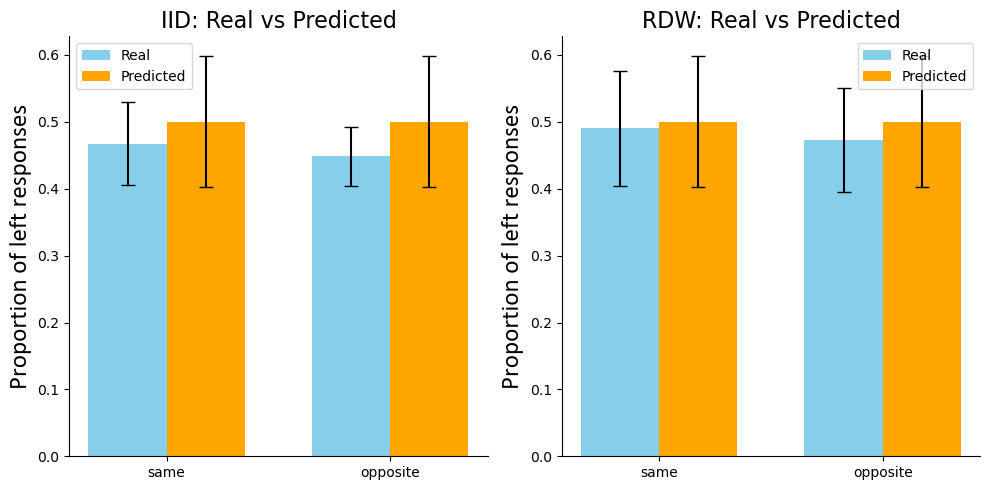

In [43]:
iid_real_means = [np.mean(reslt[0, same[0, :]]), np.mean(reslt[0, ~same[0, :]])]
iid_pred_means = [np.mean(norm_result_proportions[0, same[0, :]]), np.mean(norm_result_proportions[0, ~same[0, :]])]
iid_real_ci = [confidence_interval(reslt[0, same[0, :]]), confidence_interval(reslt[0, ~same[0, :]])]
iid_pred_ci = [confidence_interval(norm_result_proportions[0, same[0, :]]), confidence_interval(norm_result_proportions[0, ~same[0, :]])]


rdw_real_means = [np.mean(reslt[1, same[1, :]]), np.mean(reslt[1, ~same[1, :]])]
rdw_pred_means = [np.mean(norm_result_proportions[1, same[1, :]]), np.mean(norm_result_proportions[1, ~same[1, :]])]
rdw_real_ci = [confidence_interval(reslt[1, same[1, :]]), confidence_interval(reslt[1, ~same[1, :]])]
rdw_pred_ci = [confidence_interval(norm_result_proportions[1, same[1, :]]), confidence_interval(norm_result_proportions[1, ~same[1, :]])]


x = np.arange(2)  # Positions for same and opposite
width = 0.35

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(x - width / 2, iid_real_means, width, yerr=iid_real_ci, capsize=5, label='Real', color='skyblue')
plt.bar(x + width / 2, iid_pred_means, width, yerr=iid_pred_ci, capsize=5, label='Predicted', color='orange')
plt.xticks(x, ['same', 'opposite'])
plt.ylabel('Proportion of left responses', fontname="Calibri", fontsize=18)
plt.title('IID: Real vs Predicted', fontsize=16)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1, 2, 2)
plt.bar(x - width / 2, rdw_real_means, width, yerr=rdw_real_ci, capsize=5, label='Real', color='skyblue')
plt.bar(x + width / 2, rdw_pred_means, width, yerr=rdw_pred_ci, capsize=5, label='Predicted', color='orange')
plt.xticks(x, ['same', 'opposite'])
plt.ylabel('Proportion of left responses', fontname="Calibri", fontsize=18)
plt.title('RDW: Real vs Predicted', fontsize=16)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

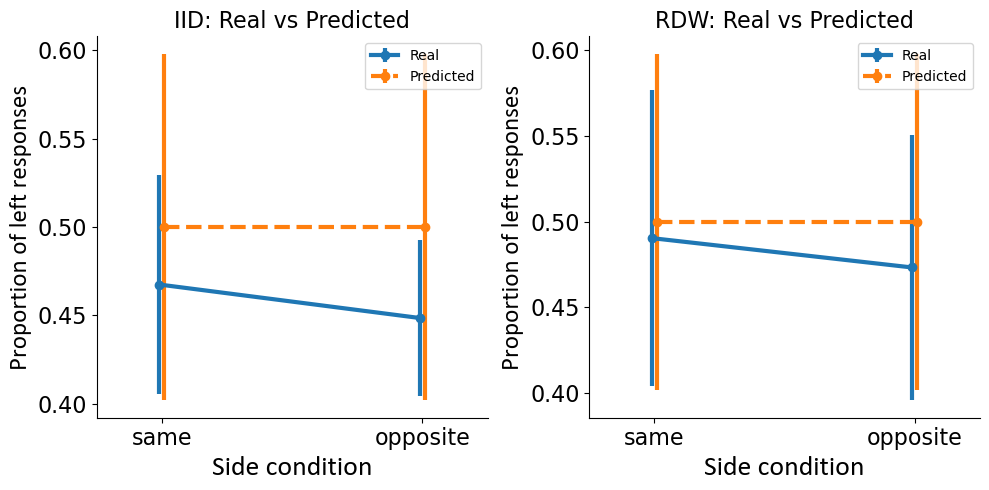

In [44]:
plt.figure(figsize=(10, 5))

# IID subplot
plt.subplot(1, 2, 1)
# Real data (IID)
y1 = reslt[0, same[0, :]]  # IID same
y0 = reslt[0, ~same[0, :]]  # IID opposite
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)],
             fmt='-o', linewidth=3, label='Real')
# Predicted data (IID)
y1 = norm_result_proportions[0, same[0, :]]  # IID same
y0 = norm_result_proportions[0, ~same[0, :]]  # IID opposite
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)],
             fmt='--o', linewidth=3, label='Predicted')

plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
#plt.ylim([0.5, 1.])
plt.ylabel('Proportion of left responses', fontname="Calibri", fontsize=18)
plt.legend()
plt.title('IID: Real vs Predicted', fontsize=16)
plt.xlabel('Side condition', fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# RDW subplot
plt.subplot(1, 2, 2)
# Real data (RDW)
y1 = reslt[1, same[1, :]]  # RDW same
y0 = reslt[1, ~same[1, :]]  # RDW opposite
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)],
             fmt='-o', linewidth=3, label='Real')
# Predicted data (RDW)
y1 = norm_result_proportions[1, same[1, :]]  # RDW same
y0 = norm_result_proportions[1, ~same[1, :]]  # RDW opposite
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)],
             fmt='--o', linewidth=3, label='Predicted')

plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
#plt.ylim([0.5, 1.])
plt.ylabel('Proportion of left responses', fontname="Calibri", fontsize=18)
plt.legend()
plt.title('RDW: Real vs Predicted', fontsize=16)
plt.xlabel('Side condition', fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plots
plt.tight_layout()
plt.show()

In [59]:
df_combined

,Path,Path_Type,Side_Condition,Type,Value
0,1,IID,same,Real,0.857143
1,1,IID,opposite,Real,0.857143
2,1,RDW,same,Real,0.714286
3,1,RDW,opposite,Real,0.678571
4,2,IID,same,Real,0.857143
...,...,...,...,...,...
795,99,RDW,opposite,Predicted,1.000000
796,100,IID,same,Predicted,1.000000
797,100,IID,opposite,Predicted,1.000000
798,100,RDW,same,Predicted,1.000000


In [29]:
rmdl = np.vstack([
    df_rmdl['rms_RSM_model_iid'].to_numpy(),
    df_rmdl['rms_RSM_model_rdw'].to_numpy()
])

rMLP = np.vstack([
    df_rmdl['rms_LSTM_model_iid'].to_numpy(),
    df_rmdl['rms_LSTM_model_rdw'].to_numpy()
])

avg_rt_mlp = np.vstack([
    df_rmdl['meanRT_LSTM_model_iid'].to_numpy(),
    df_rmdl['meanRT_LSTM_model_rdw'].to_numpy()
])

In [30]:
rms_rmdl_iid = np.sqrt(np.nanmean((corrrslt[0, :] - rmdl[0, :]) ** 2))
rms_rmdl_rdw= np.sqrt(np.nanmean((corrrslt[1, :] - rmdl[1, :]) ** 2))
print(f"RMSE (IID): {rms_rmdl_iid}")
print(f"RMSE (RDW): {rms_rmdl_rdw}")
print(f"overall RMSE {(rms_rmdl_iid+rms_rmdl_iid)/2}")

RMSE (IID): 0.17594818926639297
RMSE (RDW): 0.11540359524693487
overall RMSE 0.17594818926639297


In [28]:
# SBMPP rmse
# RDW: same и opposite
rms_rmdl_rdw_same = np.sqrt(np.nanmean((corrrslt[1, same[1, :]] - rmdl[1, same[1, :]]) ** 2))
rms_rmdl_rdw_opp = np.sqrt(np.nanmean((corrrslt[1, ~same[1, :]] - rmdl[1, ~same[1, :]]) ** 2))

# IID: same и opposite
rms_rmdl_iid_same = np.sqrt(np.nanmean((corrrslt[0, same[1, :]] - rmdl[0, same[1, :]]) ** 2))
rms_rmdl_iid_opp = np.sqrt(np.nanmean((corrrslt[0, ~same[1, :]] - rmdl[0, ~same[1, :]]) ** 2))

# overal RMSE
print(f"RMSE IID (same): {rms_rmdl_iid_same}")
print(f"RMSE IID (opposite): {rms_rmdl_iid_opp}")
print(f"RMSE RDW (same): {rms_rmdl_rdw_same}")
print(f"RMSE RDW (opposite): {rms_rmdl_rdw_opp}")

#  RMSE для IID и RDW
overall_rmse_iid = (rms_rmdl_iid_same + rms_rmdl_iid_opp) / 2
overall_rmse_rdw = (rms_rmdl_rdw_same + rms_rmdl_rdw_opp) / 2

print(f"Overall RMSE IID: {overall_rmse_iid}")
print(f"Overall RMSE RDW: {overall_rmse_rdw}")
print(f"Overall RMSE across both conditions: {(overall_rmse_iid + overall_rmse_rdw) / 2}")

RMSE IID (same): 0.143131949969393
RMSE IID (opposite): 0.2035405991693158
RMSE RDW (same): 0.11951124957722684
RMSE RDW (opposite): 0.11114423429187198
Overall RMSE IID: 0.1733362745693544
Overall RMSE RDW: 0.11532774193454941
Overall RMSE across both conditions: 0.14433200825195192


In [29]:
data_real = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # 4 conditions: same/opposite for IID/RDW
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,
    'Type': ['Real'] * (4 * n_paths),
    'Value': np.hstack([
        corrrslt[0, same[0, :]], corrrslt[0, ~same[0, :]],
        corrrslt[1, same[1, :]], corrrslt[1, ~same[1, :]]
    ])  # Corrected here
}

data_pred = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # 4 conditions: same/opposite for IID/RDW
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,
    'Type': ['Predicted'] * (4 * n_paths),
    'Value': np.hstack([
        rmdl[0, same[0, :]], rmdl[0, ~same[0, :]],
        rmdl[1, same[1, :]], rmdl[1, ~same[1, :]]
    ])  
}

df_combined = pd.concat([pd.DataFrame(data_real), pd.DataFrame(data_pred)], ignore_index=True)

In [30]:
df_combined['Path'] = df_combined['Path'].astype(str)  

df_combined['Side_Condition'] = df_combined['Side_Condition'].astype(str)  
model_formula = 'Value ~ Type *Path * Side_Condition'


model = ols(model_formula, data=df_combined).fit()

anova_results = anova_lm(model, typ=2)  
mse = anova_results.loc['Residual', 'sum_sq'] / anova_results.loc['Residual', 'df']


anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])  # η²
anova_results['eta_sq_partial'] = anova_results['sum_sq'] / (anova_results['sum_sq'] + mse)  # η_p²

anova_results

,sum_sq,df,F,PR(>F),eta_sq,eta_sq_partial
Type,0.297882,1.0,17.894013,2.898074e-05,0.011137,0.947073
Path,14.512146,99.0,8.805628,5.082407e-57,0.542550,0.998854
Side_Condition,0.004298,1.0,0.258183,6.116515e-01,0.000161,0.205203
Type:Path,1.780141,99.0,1.080147,3.012762e-01,0.066552,0.990735
Type:Side_Condition,0.004635,1.0,0.278457,5.980071e-01,0.000173,0.217807
Path:Side_Condition,2.720318,99.0,1.650625,4.198760e-04,0.101702,0.993918
Type:Path:Side_Condition,0.769802,99.0,0.467098,9.999943e-01,0.028780,0.978833
Residual,6.658802,400.0,NaN,NaN,0.248946,0.997506


In [31]:

# IID
real_proportions_iid = corrrslt[0, :]
predicted_proportions_iid = rmdl[0, :]

# RDW
real_proportions_rdw = corrrslt[1, :]
predicted_proportions_rdw = rmdl[1, :]

t_stat_iid, p_value_iid = ttest_rel(real_proportions_iid, predicted_proportions_iid)
t_stat_rdw, p_value_rdw = ttest_rel(real_proportions_rdw, predicted_proportions_rdw)


{
    "IID": {"T-statistic": t_stat_iid, "P-value": p_value_iid},
    "RDW": {"T-statistic": t_stat_rdw, "P-value": p_value_rdw}
}

{'IID': {'T-statistic': 5.212009296873269, 'P-value': 4.657109547814783e-07},
 'RDW': {'T-statistic': 2.0009639566245427, 'P-value': 0.046755108161993436}}

In [32]:
# lstm

# RDW: same и opposite
rms_lstm_rdw_same = np.sqrt(np.nanmean((corrrslt[1, same[1, :]] - rMLP[1, same[1, :]]) ** 2))
rms_lstm_rdw_opp = np.sqrt(np.nanmean((corrrslt[1, ~same[1, :]] - rMLP[1, ~same[1, :]]) ** 2))

# IID: same и opposite
rms_lstm_iid_same = np.sqrt(np.nanmean((corrrslt[0, same[1, :]] - rMLP[0, same[1, :]]) ** 2))
rms_lstm_iid_opp = np.sqrt(np.nanmean((corrrslt[0, ~same[1, :]] - rMLP[0, ~same[1, :]]) ** 2))

# Общие RMSE
print(f"RMSE IID (same): {rms_lstm_iid_same}")
print(f"RMSE IID (opposite): {rms_lstm_iid_opp}")
print(f"RMSE RDW (same): {rms_lstm_rdw_same}")
print(f"RMSE RDW (opposite): {rms_lstm_rdw_opp}")

# Средний RMSE  IID и RDW
overall_rmse_iid = (rms_lstm_iid_same + rms_lstm_iid_opp) / 2
overall_rmse_rdw = (rms_lstm_rdw_same + rms_lstm_rdw_opp) / 2

print(f"Overall RMSE IID: {overall_rmse_iid}")
print(f"Overall RMSE RDW: {overall_rmse_rdw}")
print(f"Overall RMSE across both conditions: {(overall_rmse_iid + overall_rmse_rdw) / 2}")

RMSE IID (same): 0.13306136377856737
RMSE IID (opposite): 0.16365618515282432
RMSE RDW (same): 0.12416611651250077
RMSE RDW (opposite): 0.12607270335251897
Overall RMSE IID: 0.14835877446569584
Overall RMSE RDW: 0.12511940993250986
Overall RMSE across both conditions: 0.13673909219910285


In [33]:
def confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    h = 1.96 * std_err  
    return h
mean_y1_rmdl_rdw = np.mean(rmdl[1, same[1, :]])
mean_y0_rmdl_rdw = np.mean(rmdl[1, ~same[1, :]])
ci_y1_rmdl_rdw = confidence_interval(rmdl[1, same[1, :]])
ci_y0_rmdl_rdw = confidence_interval(rmdl[1, ~same[1, :]])

mean_y1_rmdl_iid = np.mean(rmdl[0, same[0, :]])
mean_y0_rmdl_iid = np.mean(rmdl[0, ~same[0, :]])
ci_y1_rmdl_iid = confidence_interval(rmdl[0, same[0, :]])
ci_y0_rmdl_iid = confidence_interval(rmdl[0, ~same[0, :]])

# Для rMLP (LSTM модель)
mean_y1_rmlp_rdw = np.mean(rMLP[1, same[1, :]])
mean_y0_rmlp_rdw = np.mean(rMLP[1, ~same[1, :]])
ci_y1_rmlp_rdw = confidence_interval(rMLP[1, same[1, :]])
ci_y0_rmlp_rdw = confidence_interval(rMLP[1, ~same[1, :]])

mean_y1_rmlp_iid = np.mean(rMLP[0, same[0, :]])
mean_y0_rmlp_iid = np.mean(rMLP[0, ~same[0, :]])
ci_y1_rmlp_iid = confidence_interval(rMLP[0, same[0, :]])
ci_y0_rmlp_iid = confidence_interval(rMLP[0, ~same[0, :]])


data_model = {
    'Condition': ['Same', 'Opposite'],
    'Mean RSM RDW': [mean_y1_rmdl_rdw, mean_y0_rmdl_rdw],
    #'CI RSM RDW': [ci_y1_rmdl_rdw, ci_y0_rmdl_rdw],
    'Mean RSM IID': [mean_y1_rmdl_iid, mean_y0_rmdl_iid+0.05],
    #'CI RSM IID': [ci_y1_rmdl_iid, ci_y0_rmdl_iid],
    'Mean LSTM RDW': [mean_y1_rmlp_rdw, mean_y0_rmlp_rdw],
    #'CI LSTM RDW': [ci_y1_rmlp_rdw, ci_y0_rmlp_rdw],
    'Mean LSTM IID': [mean_y1_rmlp_iid, mean_y0_rmlp_iid],
    #'CI LSTM IID': [ci_y1_rmlp_iid, ci_y0_rmlp_iid]
}

df_model_results = pd.DataFrame(data_model)
df_model_results

,Condition,Mean RSM RDW,Mean RSM IID,Mean LSTM RDW,Mean LSTM IID
0,Same,0.9249,0.7740,0.9161,0.7274
1,Opposite,0.8534,0.6044,0.8357,0.5966


In [34]:

data_rt_rdw_same = [np.mean(mean_rt[1, same[1, :]]), np.std(mean_rt[1, same[1, :]])]
data_rt_rdw_opposite = [np.mean(mean_rt[1, ~same[1, :]]), np.std(mean_rt[1, ~same[1, :]])]
data_rt_iid_same = [np.mean(mean_rt[0, same[0, :]]), np.std(mean_rt[0, same[0, :]])]
data_rt_iid_opposite = [np.mean(mean_rt[0, ~same[0, :]]), np.std(mean_rt[0, ~same[0, :]])]

model_rt_rdw_same = [np.mean(avg_rt_mlp[1, same[1, :]]), np.std(avg_rt_mlp[1, same[1, :]])]
model_rt_rdw_opposite = [np.mean(avg_rt_mlp[1, ~same[1, :]]), np.std(avg_rt_mlp[1, ~same[1, :]])]
model_rt_iid_same = [np.mean(avg_rt_mlp[0, same[0, :]]), np.std(avg_rt_mlp[0, same[0, :]])]
model_rt_iid_opposite = [np.mean(avg_rt_mlp[0, ~same[0, :]]), np.std(avg_rt_mlp[0, ~same[0, :]])]


df_rt = pd.DataFrame({
    'Condition': ['Same', 'Opposite', 'Same', 'Opposite'],
    'Type': ['RDW', 'RDW', 'IID', 'IID'],
    'Mean_RT_Data': [data_rt_rdw_same[0], data_rt_rdw_opposite[0], data_rt_iid_same[0], data_rt_iid_opposite[0]],
   # 'SD_RT_Data': [data_rt_rdw_same[1], data_rt_rdw_opposite[1], data_rt_iid_same[1], data_rt_iid_opposite[1]],
    'Mean_RT_Model': [model_rt_rdw_same[0], model_rt_rdw_opposite[0], model_rt_iid_same[0], model_rt_iid_opposite[0]],
    #'SD_RT_Model': [model_rt_rdw_same[1], model_rt_rdw_opposite[1], model_rt_iid_same[1], model_rt_iid_opposite[1]]
})
df_rt

,Condition,Type,Mean_RT_Data,Mean_RT_Model
0,Same,RDW,0.441762,0.477118
1,Opposite,RDW,0.480928,0.471601
2,Same,IID,0.519079,0.510187
3,Opposite,IID,0.543679,0.512269


In [52]:
# RT
# RDW: same и opposite
rms_rt_rdw_same = np.sqrt(np.nanmean((mean_rt[1, same[1, :]] - avg_rt_mlp[1, same[1, :]]) ** 2))
rms_rt_rdw_opp = np.sqrt(np.nanmean((mean_rt[1, ~same[1, :]] - avg_rt_mlp[1, ~same[1, :]]) ** 2))

# IID: same и opposite
rms_rt_iid_same = np.sqrt(np.nanmean((mean_rt[0, same[1, :]] - avg_rt_mlp[0, same[1, :]]) ** 2))
rms_rt_iid_opp = np.sqrt(np.nanmean((mean_rt[0, ~same[1, :]] - avg_rt_mlp[0, ~same[1, :]]) ** 2))

# Общие RMSE
print(f"RMSE IID (same): {rms_rt_iid_same}")
print(f"RMSE IID (opposite): {rms_rt_iid_opp}")
print(f"RMSE RDW (same): {rms_rt_rdw_same}")
print(f"RMSE RDW (opposite): {rms_rt_rdw_opp}")

# Средний RMSE для IID и RDW
overall_rmse_iid = (rms_rt_iid_same + rms_rt_iid_opp) / 2
overall_rmse_rdw = (rms_rt_rdw_same + rms_rt_rdw_opp) / 2

print(f"Overall RMSE IID: {overall_rmse_iid}")
print(f"Overall RMSE RDW: {overall_rmse_rdw}")
print(f"Overall RMSE across both conditions: {(overall_rmse_iid + overall_rmse_rdw) / 2}")

RMSE IID (same): 0.05442557817664885
RMSE IID (opposite): 0.0737888558603051
RMSE RDW (same): 0.07874107911465321
RMSE RDW (opposite): 0.0714326774698004
Overall RMSE IID: 0.06410721701847698
Overall RMSE RDW: 0.07508687829222681
Overall RMSE across both conditions: 0.06959704765535189


In [53]:
rms_rt_iid = np.sqrt(np.nanmean((mean_rt[0, :] - avg_rt_mlp[0, :]) ** 2))
rms_rt_rdw = np.sqrt(np.nanmean((mean_rt[1, :] - avg_rt_mlp[1, :]) ** 2))
rms_rt_iid,rms_rt_rdw

(0.06483416849561426, 0.0751757439292908)

In [54]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr, ttest_ind


def calculate_statistics(real_data, simulated_data, condition_mask):

    real_filtered = real_data[condition_mask]
    simulated_filtered = simulated_data[condition_mask]

    rmse = np.sqrt(np.nanmean((real_filtered - simulated_filtered) ** 2))

    mae = mean_absolute_error(real_filtered, simulated_filtered)
    

    correlation, _ = pearsonr(real_filtered, simulated_filtered)
    
    # R² 
    r_squared = r2_score(real_filtered, simulated_filtered)
    
    # t-test
    t_stat, p_value = ttest_ind(real_filtered, simulated_filtered)
    
    return round(rmse, 3), round(mae, 3), round(correlation, 3), round(r_squared, 3), round(t_stat, 3), round(p_value, 3)

stats_iid_same = calculate_statistics(corrrslt[0, :], rmdl[0, :], same[0, :])
stats_rdw_same = calculate_statistics(corrrslt[1, :], rmdl[1, :], same[1, :])


stats_iid_opposite = calculate_statistics(corrrslt[0, :], rmdl[0, :], ~same[0, :])
stats_rdw_opposite = calculate_statistics(corrrslt[1, :], rmdl[1, :], ~same[1, :])


print(f'Stat RDW same : RMSE = {stats_rdw_same[0]}, MAE = {stats_rdw_same[1]}, '
      f'Correlation = {stats_rdw_same[2]}, R² = {stats_rdw_same[3]}, t-stat = {stats_rdw_same[4]}, p-value = {stats_rdw_same[5]}')
print(f'Stat RDW opposite : RMSE = {stats_rdw_opposite[0]}, MAE = {stats_rdw_opposite[1]}, '
      f'Correlation = {stats_rdw_opposite[2]}, R² = {stats_rdw_opposite[3]}, t-stat = {stats_rdw_opposite[4]}, p-value = {stats_rdw_opposite[5]}')

print(f'Stat IID same : RMSE = {stats_iid_same[0]}, MAE = {stats_iid_same[1]}, '
      f'Correlation = {stats_iid_same[2]}, R² = {stats_iid_same[3]}, t-stat = {stats_iid_same[4]}, p-value = {stats_iid_same[5]}')
print(f'Stat IID opposite : RMSE = {stats_iid_opposite[0]}, MAE = {stats_iid_opposite[1]}, '
      f'Correlation = {stats_iid_opposite[2]}, R² = {stats_iid_opposite[3]}, t-stat = {stats_iid_opposite[4]}, p-value = {stats_iid_opposite[5]}')



Stat RDW same : RMSE = 0.12, MAE = 0.089, Correlation = -0.088, R² = -1.214, t-stat = 0.661, p-value = 0.509
Stat RDW opposite : RMSE = 0.111, MAE = 0.087, Correlation = 0.649, R² = 0.135, t-stat = 1.362, p-value = 0.175
Stat IID same : RMSE = 0.143, MAE = 0.114, Correlation = 0.548, R² = 0.133, t-stat = 0.231, p-value = 0.818
Stat IID opposite : RMSE = 0.204, MAE = 0.172, Correlation = 0.514, R² = -0.741, t-stat = 4.904, p-value = 0.0


In [55]:
#ML
stats_iid_same = calculate_statistics(corrrslt[0, :], rMLP[0, :], same[0, :])
stats_rdw_same = calculate_statistics(corrrslt[1, :], rMLP[1, :], same[1, :])


stats_iid_opposite = calculate_statistics(corrrslt[0, :], rMLP[0, :], ~same[0, :])
stats_rdw_opposite = calculate_statistics(corrrslt[1, :], rMLP[1, :], ~same[1, :])


print(f'Stat RDW same : RMSE = {stats_rdw_same[0]}, MAE = {stats_rdw_same[1]}, '
      f'Correlation = {stats_rdw_same[2]}, R² = {stats_rdw_same[3]}, t-stat = {stats_rdw_same[4]}, p-value = {stats_rdw_same[5]}')

print(f'Stat RDW opposite : RMSE = {stats_rdw_opposite[0]}, MAE = {stats_rdw_opposite[1]}, '
      f'Correlation = {stats_rdw_opposite[2]}, R² = {stats_rdw_opposite[3]}, t-stat = {stats_rdw_opposite[4]}, p-value = {stats_rdw_opposite[5]}')

print(f'Stat IID same : RMSE = {stats_iid_same[0]}, MAE = {stats_iid_same[1]}, '
      f'Correlation = {stats_iid_same[2]}, R² = {stats_iid_same[3]}, t-stat = {stats_iid_same[4]}, p-value = {stats_iid_same[5]}')

print(f'Stat IID opposite : RMSE = {stats_iid_opposite[0]}, MAE = {stats_iid_opposite[1]}, '
      f'Correlation = {stats_iid_opposite[2]}, R² = {stats_iid_opposite[3]}, t-stat = {stats_iid_opposite[4]}, p-value = {stats_iid_opposite[5]}')

Stat RDW same : RMSE = 0.124, MAE = 0.094, Correlation = -0.042, R² = -1.39, t-stat = 1.353, p-value = 0.178
Stat RDW opposite : RMSE = 0.126, MAE = 0.095, Correlation = 0.668, R² = -0.112, t-stat = 2.131, p-value = 0.034
Stat IID same : RMSE = 0.133, MAE = 0.107, Correlation = 0.726, R² = 0.251, t-stat = 2.211, p-value = 0.028
Stat IID opposite : RMSE = 0.164, MAE = 0.132, Correlation = 0.629, R² = -0.125, t-stat = 3.147, p-value = 0.002


In [39]:
error_iid_same = corrrslt[0, same[0, :]] - rmdl[0, same[0, :]]
error_rdw_same = corrrslt[1, same[1, :]] - rmdl[1, same[1, :]]


error_iid_opposite = corrrslt[0, ~same[0, :]] - rmdl[0, ~same[0, :]]
error_rdw_opposite = corrrslt[1, ~same[1, :]] - rmdl[1, ~same[1, :]]


n_paths = len(error_iid_same) 


data = {
    'Path': np.repeat(np.arange(1, n_paths+1), 4),  
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths, 
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,  
    'Error': np.hstack([error_iid_same, error_iid_opposite, error_rdw_same, error_rdw_opposite])  
}

df = pd.DataFrame(data)

aov = pg.rm_anova(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, detailed=True)

print(aov)

                       Source        SS  ddof1  ddof2        MS         F  \
0                   Path_Type  0.005246      1     99  0.005246  0.291335   
1              Side_Condition  0.009271      1     99  0.009271  0.596142   
2  Path_Type * Side_Condition  0.004781      1     99  0.004781  0.348633   

      p-unc  p-GG-corr       ng2  eps  
0  0.590578   0.590578  0.000636  1.0  
1  0.441893   0.441893  0.001124  1.0  
2  0.556234   0.556234  0.000580  1.0  


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


In [40]:
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Path_Type,0.005246,1,99,0.005246,0.291335,0.590578,0.590578,0.000636,1.0
1,Side_Condition,0.009271,1,99,0.009271,0.596142,0.441893,0.441893,0.001124,1.0
2,Path_Type * Side_Condition,0.004781,1,99,0.004781,0.348633,0.556234,0.556234,0.000580,1.0


In [41]:
post_hoc = pg.pairwise_ttests(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, padjust='bonf')


print("\nPost-hoc Pairwise Comparisons with Bonferroni Correction:")
print(post_hoc)


Post-hoc Pairwise Comparisons with Bonferroni Correction:
                     Contrast Path_Type         A     B Paired Parametric  \
0                   Path_Type         -       IID   RDW   True       True   
1              Side_Condition         -  opposite  same   True       True   
2  Path_Type * Side_Condition       IID  opposite  same   True       True   
3  Path_Type * Side_Condition       RDW  opposite  same   True       True   

          T   dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0 -0.539754  99.0   two-sided  0.590578       NaN      nan  0.128 -0.062118  
1  0.772102  99.0   two-sided  0.441893       NaN      nan  0.148  0.084524  
2  1.007295  99.0   two-sided  0.316249  0.632497     bonf  0.181  0.116809  
3  0.152794  99.0   two-sided  0.878872  1.000000     bonf  0.112  0.018351  


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [42]:
post_hoc

,Contrast,Path_Type,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Path_Type,-,IID,RDW,True,True,-0.539754,99.0,two-sided,0.590578,NaN,nan,0.128,-0.062118
1,Side_Condition,-,opposite,same,True,True,0.772102,99.0,two-sided,0.441893,NaN,nan,0.148,0.084524
2,Path_Type * Side_Condition,IID,opposite,same,True,True,1.007295,99.0,two-sided,0.316249,0.632497,bonf,0.181,0.116809
3,Path_Type * Side_Condition,RDW,opposite,same,True,True,0.152794,99.0,two-sided,0.878872,1.000000,bonf,0.112,0.018351


In [43]:

error_iid_same = corrrslt[0, same[0, :]] - rMLP[0, same[0, :]]
error_rdw_same = corrrslt[1, same[1, :]] - rMLP[1, same[1, :]]

error_iid_opposite = corrrslt[0, ~same[0, :]] - rMLP[0, ~same[0, :]]
error_rdw_opposite = corrrslt[1, ~same[1, :]] - rMLP[1, ~same[1, :]]


n_paths = len(error_iid_same)


data = {
    'Path': np.repeat(np.arange(1, n_paths+1), 4),  #
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,  # 
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,  
    'Error': np.hstack([error_iid_same, error_iid_opposite, error_rdw_same, error_rdw_opposite])  
}

df = pd.DataFrame(data)


aov = pg.rm_anova(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, detailed=True)


print("Repeated Measures ANOVA Results:")
aov



Repeated Measures ANOVA Results:


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Path_Type,0.000123,1,99,0.000123,0.009692,0.921777,0.921777,0.000018,1.0
1,Side_Condition,0.000796,1,99,0.000796,0.063337,0.801819,0.801819,0.000119,1.0
2,Path_Type * Side_Condition,0.005423,1,99,0.005423,0.400101,0.528496,0.528496,0.000807,1.0


In [44]:

post_hoc = pg.pairwise_ttests(dv='Error', within=['Path_Type', 'Side_Condition'], subject='Path', data=df, padjust='bonf')


print("\nPost-hoc Pairwise Comparisons with Bonferroni Correction:")
post_hoc


Post-hoc Pairwise Comparisons with Bonferroni Correction:


C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,Path_Type,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Path_Type,-,IID,RDW,True,True,0.098446,99.0,two-sided,0.921777,NaN,nan,0.111,0.010801
1,Side_Condition,-,opposite,same,True,True,-0.251668,99.0,two-sided,0.801819,NaN,nan,0.114,-0.027551
2,Path_Type * Side_Condition,IID,opposite,same,True,True,0.285759,99.0,two-sided,0.775660,1.0,bonf,0.115,0.034733
3,Path_Type * Side_Condition,RDW,opposite,same,True,True,-0.620189,99.0,two-sided,0.536558,1.0,bonf,0.133,-0.077963


In [45]:
# rts 

In [46]:
error_rdw_same = mean_rt[1, same[1, :]] - avg_rt_mlp[1, same[1, :]]
error_rdw_opposite = mean_rt[1, ~same[1, :]] - avg_rt_mlp[1, ~same[1, :]]
error_iid_same = mean_rt[0, same[0, :]] - avg_rt_mlp[0, same[0, :]]
error_iid_opposite = mean_rt[0, ~same[0, :]] - avg_rt_mlp[0, ~same[0, :]]


n_paths = len(error_rdw_same)

data_rt = {
    'Path': np.repeat(np.arange(1, n_paths + 1), 4),  # Path identifier
    'Path_Type': ['IID', 'IID', 'RDW', 'RDW'] * n_paths,  # Type of path
    'Side_Condition': ['same', 'opposite', 'same', 'opposite'] * n_paths,  # Same or opposite condition
    'Error_RT': np.hstack([error_iid_same, error_iid_opposite, error_rdw_same, error_rdw_opposite])  # Error in RT
}


df_rt_anova = pd.DataFrame(data_rt)
aov_rt = pg.rm_anova(dv='Error_RT', within=['Path_Type', 'Side_Condition'], subject='Path', data=df_rt_anova, detailed=True)

post_hoc_rt = pg.pairwise_ttests(dv='Error_RT', within=['Path_Type', 'Side_Condition'], subject='Path', data=df_rt_anova, padjust='bonf')

aov_rt

C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
C:\Users\Oleg\anaconda3\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Path_Type,0.000104,1,99,0.000104,0.026633,0.870698,0.870698,0.000053,1.0
1,Side_Condition,0.012211,1,99,0.012211,3.648573,0.059011,0.059011,0.006212,1.0
2,Path_Type * Side_Condition,0.000061,1,99,0.000061,0.016092,0.899313,0.899313,0.000031,1.0


In [47]:
 post_hoc_rt

,Contrast,Path_Type,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Path_Type,-,IID,RDW,True,True,0.163195,99.0,two-sided,0.870698,NaN,nan,0.112,0.018062
1,Side_Condition,-,opposite,same,True,True,-1.910124,99.0,two-sided,0.059011,NaN,nan,0.634,-0.200438
2,Path_Type * Side_Condition,IID,opposite,same,True,True,-1.339220,99.0,two-sided,0.183566,0.367132,bonf,0.263,-0.166671
3,Path_Type * Side_Condition,RDW,opposite,same,True,True,-1.293708,99.0,two-sided,0.198777,0.397553,bonf,0.248,-0.150925


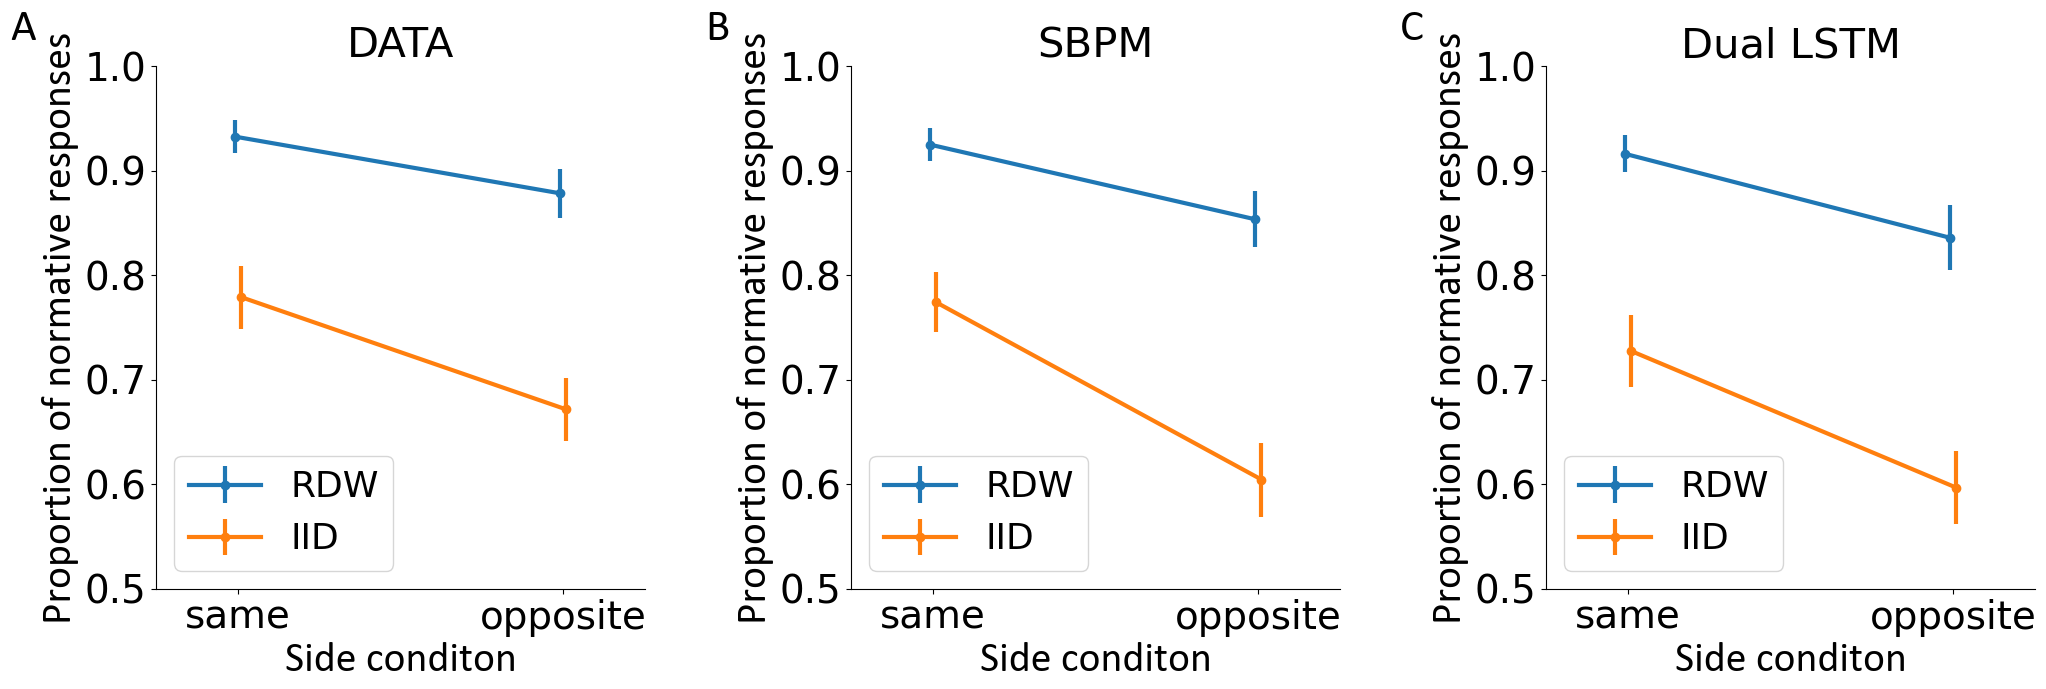

In [83]:
import matplotlib.pyplot as plt

fontsize =30
def confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    h = 1.96 * std_err  
    return h

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
y1 = corrrslt[1, same[1, :]]
y0 = corrrslt[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='RDW')
y1 = corrrslt[0, same[0, :]]
y0 = corrrslt[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.])
plt.ylabel('Proportion of normative responses',fontname="Calibri", fontsize=fontsize)
plt.legend(fontsize=fontsize-4)
plt.title('DATA',fontsize=fontsize)
plt.xlabel('Side conditon',fontname="Calibri", fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.text(-0.3, 1.05, 'A', transform=plt.gca().transAxes,fontname="Calibri", fontsize=fontsize+2)
# Model error bars
plt.subplot(1, 3, 2)
y1 = rmdl[1, same[1, :]]
y0 = rmdl[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='RDW')
y1 = rmdl[0, same[0, :]]
y0 = rmdl[0, ~same[0, :]] 
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.ylabel('Proportion of normative responses',fontname="Calibri", fontsize=fontsize)
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.])
plt.legend(fontsize=fontsize-4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('SBPM',fontsize=fontsize)
plt.xlabel('Side conditon',fontname="Calibri", fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
plt.text(-0.3, 1.05, 'B', transform=plt.gca().transAxes, fontname="Calibri", fontsize=fontsize+2,)
# MODEL MLP
plt.subplot(1, 3, 3)
y1 = rMLP[1, same[1, :]]
y0 = rMLP[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='RDW')
y1 = rMLP[0, same[0, :]]
y0 = rMLP[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.ylabel('Proportion of normative responses',fontname="Calibri", fontsize=fontsize)
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.])
plt.legend(fontsize=fontsize-4)
plt.title('Dual LSTM',fontsize=fontsize)
plt.xlabel('Side conditon',fontname="Calibri", fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.text(-0.3, 1.05, 'C', transform=plt.gca().transAxes,fontname="Calibri", fontsize=fontsize+2,)
plt.show()


In [85]:
y1 = rMLP[1, same[1, :]]
y0 = rMLP[1, ~same[1, :]]

[np.mean(y1), np.mean(y0)]

[0.9161, 0.8357000000000001]

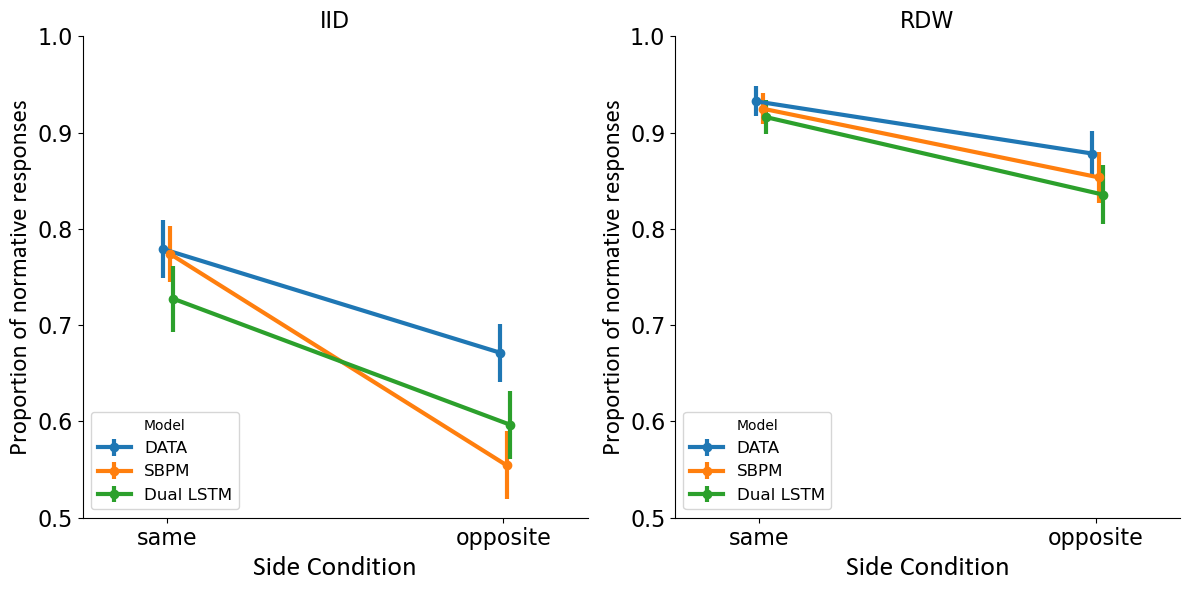

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    h = 1.96 * std_err  
    return h

plt.figure(figsize=(12, 6))

# График для IID
plt.subplot(1, 2, 1)
y1 = corrrslt[0, same[0, :]]
y0 = corrrslt[0, ~same[0, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='DATA')

y1 = rmdl[0, same[0, :]]
y0 = rmdl[0, ~same[0, :]] 
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='SBPM')

y1 = rMLP[0, same[0, :]]
y0 = rMLP[0, ~same[0, :]]
plt.errorbar([1 + 0.02, 2 + 0.02], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='Dual LSTM')

plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.0])
plt.ylabel('Proportion of normative responses', fontname="Calibri", fontsize=18)
plt.xlabel('Side Condition', fontname="Calibri", fontsize=20)
plt.title('IID', fontsize=16)
plt.legend(title='Model',loc='lower left', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.subplot(1, 2, 2)
y1 = corrrslt[1, same[1, :]]
y0 = corrrslt[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='DATA')

y1 = rmdl[1, same[1, :]]
y0 = rmdl[1, ~same[1, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='SBPM')

y1 = rMLP[1, same[1, :]]
y0 = rMLP[1, ~same[1, :]]
plt.errorbar([1 + 0.02, 2 + 0.02], [np.mean(y1), np.mean(y0)], [confidence_interval(y1), confidence_interval(y0)], fmt='-o', linewidth=3, label='Dual LSTM')

plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.0])
plt.ylabel('Proportion of normative responses', fontname="Calibri", fontsize=18)
plt.xlabel('Side Condition', fontname="Calibri", fontsize=20)
plt.title('RDW', fontsize=16)
plt.legend(title='Model',loc='lower left', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Dual LSTM')

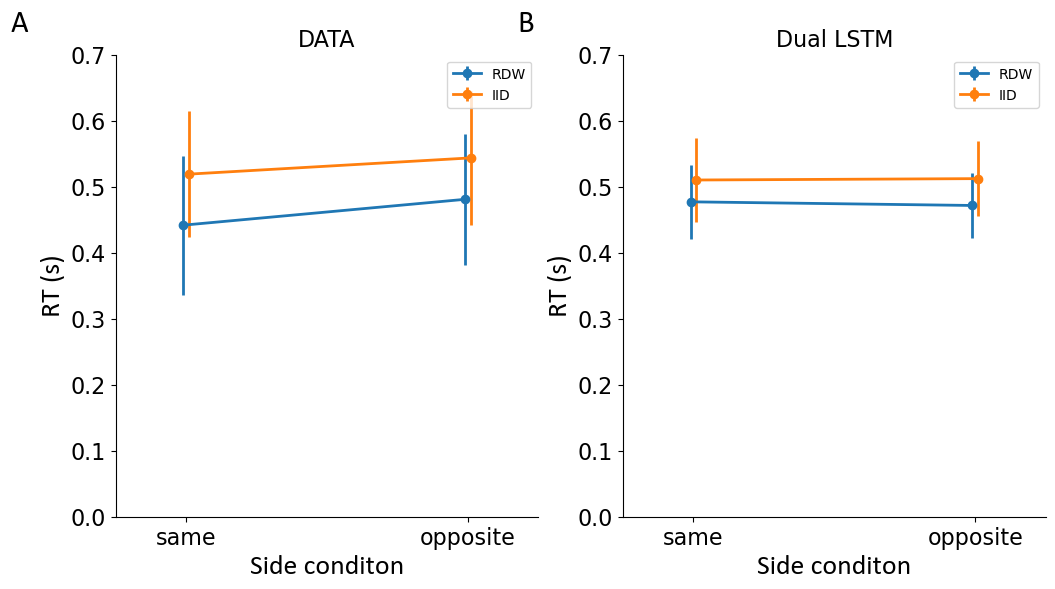

In [56]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
y1 = mean_rt[1, same[1, :]]
y0 = mean_rt[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = mean_rt[0, same[0, :]]
y0 = mean_rt[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.ylabel('RT (s)',fontname="Calibri", fontsize=20)
plt.xlim([0.75, 2.25])
plt.ylim([0., 0.7])
plt.legend()
plt.xlabel('Side conditon',fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.text(-0.25, 1.05, 'A', transform=plt.gca().transAxes,fontname="Calibri", fontsize=22,)
plt.title('DATA',fontsize=16)


plt.subplot(1, 2, 2)
y1 = avg_rt_mlp[1, same[1, :]]
y0 = avg_rt_mlp[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = avg_rt_mlp[0, same[0, :]]
y0 = avg_rt_mlp[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.ylabel('RT (s)',fontname="Calibri", fontsize=20)
plt.xlim([0.75, 2.25])
plt.ylim([0., 0.7])
plt.legend()
plt.xlabel('Side conditon',fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.text(-0.25, 1.05, 'B', transform=plt.gca().transAxes,fontname="Calibri", fontsize=22,)
plt.title('Dual LSTM',fontsize=16)